In [14]:
import pandas as pd
import numpy as np

data=pd.read_csv("/content/Mall_Customers.csv")
print(data.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [15]:
data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [16]:
#duplication
duplicate_rows=data[data.duplicated()]
print(duplicate_rows)
data_cleaned=data.drop_duplicates()
print(data_cleaned.head())

Empty DataFrame
Columns: [CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100)]
Index: []
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [17]:
#remove outlayers(z_score)
from scipy.stats import zscore
numeric_cols=data_cleaned.select_dtypes(include=[np.number]).columns
z_score=zscore(data[numeric_cols])
z_score_df=pd.DataFrame(z_score,columns=numeric_cols)
outliers=(np.abs(z_score_df)>3).any(axis=1)
data_cleaned=data[~outliers]
data_cleaned.reset_index(drop=True,inplace=True)

print(data_cleaned.head())
print("Original shape:",data.shape)
print("Cleaned shape:",data_cleaned.shape)

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
Original shape: (200, 5)
Cleaned shape: (200, 5)


In [21]:
#label encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data_cleaned.loc[:,"Gender"]=le.fit_transform(data_cleaned.loc[:,"Gender"])
print(data_cleaned.head())

   CustomerID Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1      1   19                  15                      39
1           2      1   21                  15                      81
2           3      0   20                  16                       6
3           4      0   23                  16                      77
4           5      0   31                  17                      40


In [24]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
data_normalized= pt.fit_transform(data_cleaned)
data_normalized_df = pd.DataFrame(data_normalized, columns=data_cleaned.columns)
print(data_normalized_df.head())

   CustomerID    Gender       Age  Annual Income (k$)  Spending Score (1-100)
0   -2.079376  1.128152 -1.718993           -1.989930               -0.385308
1   -2.032923  1.128152 -1.470002           -1.989930                1.164467
2   -1.990711 -0.886405 -1.591912           -1.930366               -1.820424
3   -1.951397 -0.886405 -1.240020           -1.930366                1.023549
4   -1.914247 -0.886405 -0.461118           -1.872032               -0.346103


In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled=scaler.fit_transform(data_normalized)
data_scaled_df = pd.DataFrame(data_scaled, columns=data_cleaned.columns)
print(data_scaled_df.head())

   CustomerID    Gender       Age  Annual Income (k$)  Spending Score (1-100)
0   -2.079376  1.128152 -1.718993           -1.989930               -0.385308
1   -2.032923  1.128152 -1.470002           -1.989930                1.164467
2   -1.990711 -0.886405 -1.591912           -1.930366               -1.820424
3   -1.951397 -0.886405 -1.240020           -1.930366                1.023549
4   -1.914247 -0.886405 -0.461118           -1.872032               -0.346103


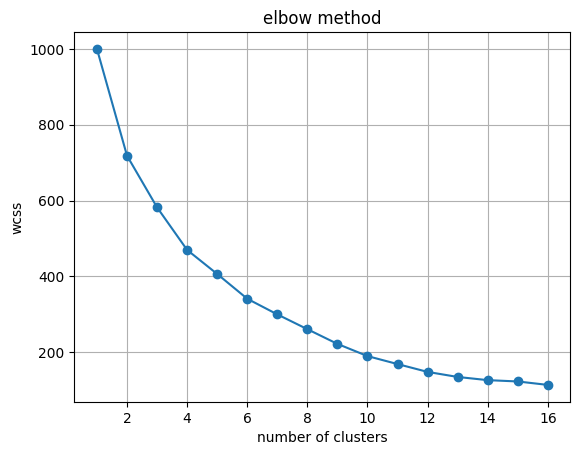

In [34]:
from sklearn.cluster import KMeans
li=[]
for i in range(1,17):
  km=KMeans(n_clusters=i,n_init=10,random_state=42)
  km.fit(data_scaled)
  li.append(km.inertia_)

import matplotlib.pyplot as plt
plt.title("elbow method")
plt.plot(range(1,17),li,marker='o') # Changed marker to 'o'
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.grid()
plt.show()

In [36]:
k=6
model=KMeans(n_clusters=k,n_init=10,random_state=42)
model.fit(data_scaled_df)
labels=model.labels_

centroids=model.cluster_centers_
data_scaled_df["Cluster"]=labels
Cluster_means=data_scaled_df.groupby('Cluster').mean()
print(Cluster_means)

         CustomerID    Gender       Age  Annual Income (k$)  \
Cluster                                                       
0         -0.549541  1.128152  1.090605           -0.514322   
1          0.659830 -0.886405 -0.553904            0.595265   
2         -1.386237  0.048925 -1.141104           -1.370846   
3          1.060572  0.264770  0.256378            1.028453   
4          0.745732  1.128152 -0.567151            0.737195   
5         -0.639421 -0.886405  0.633202           -0.581500   

         Spending Score (1-100)  
Cluster                          
0                     -0.328657  
1                      0.600504  
2                      0.810591  
3                     -1.306371  
4                      0.892501  
5                     -0.320155  


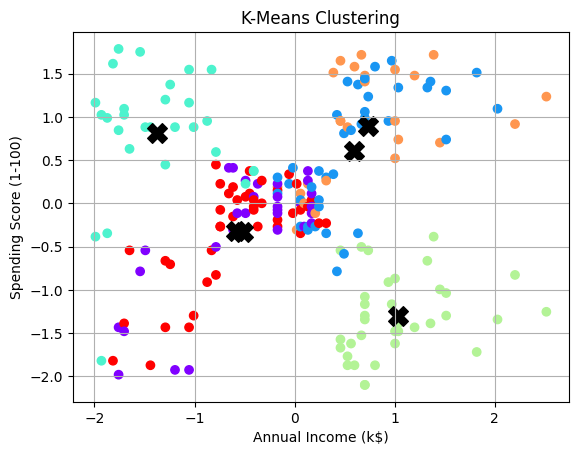

In [39]:
import matplotlib.pyplot as plt

# Convert centroids back to original scale
centroids_original = scaler.inverse_transform(model.cluster_centers_)

plt.scatter(data_scaled_df['Annual Income (k$)'], data_scaled_df['Spending Score (1-100)'], # Changed df to data_scaled_df
            c=data_scaled_df['Cluster'], cmap="rainbow")
plt.scatter(centroids_original[:, 3], centroids_original[:, 4],
            s=200, c="black", marker="X")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("K-Means Clustering")
plt.grid()
plt.show()

In [40]:
from sklearn.metrics import silhouette_score

# Example usage:
sil_score = silhouette_score(data_scaled, labels)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.3218330266456303
